In [1]:
%matplotlib notebook
import os
import numpy as np
import torch 
from torch import nn 
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import socket
import getpass
print(socket.gethostname())
print(getpass.getuser())
root_dir = "caltech_ucsd_birds"

a2pal-25354
a2pal


### Part 1

The Stanford Cars dataset root directory is created below.

In [4]:
train_dir = "images/train"
val_dir = "images/val"

image_size = (224,224)

normalize = tv.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])

train_set = tv.datasets.ImageFolder(train_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

val_set = tv.datasets.ImageFolder(val_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

<IPython.core.display.Javascript object>


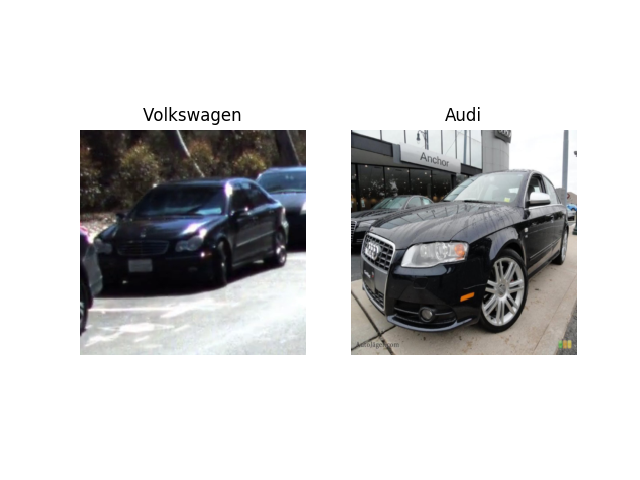

Text(0.5, 1.0, 'Volkswagen')

In [5]:

def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

# Visualize images:

x = train_set[10][0]
y = train_set[-1][0]
fig = plt.figure()
ax1 = fig.add_subplot(1,2,2)
myimshow(x,ax1)
plt.title("Audi")
ax2 = fig.add_subplot(1,2,1)
myimshow(y,ax2)
plt.title("Volkswagen")

### Part 2 - TRAINING


In [6]:
import nntools as nt
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

###  With VGG16:

In [7]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

### Stats Manager Set-up

In [8]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
        
    def summarize(self):
        loss =super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss,'accuracy': accuracy}

In [36]:
lr = 1e-3
net = VGG16Transfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass_vgg1", perform_validation_during_training=True)

In [37]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],label="evaluation accuracy")
    axes[0].legend()
    axes[1].legend()
    axes[0].set_xlabel("Epoch")
    axes[1].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")
    
    plt.tight_layout()
    fig.canvas.draw()

Start/Continue training from epoch 0
Epoch 1 (Time: 44.92s)


KeyboardInterrupt: 

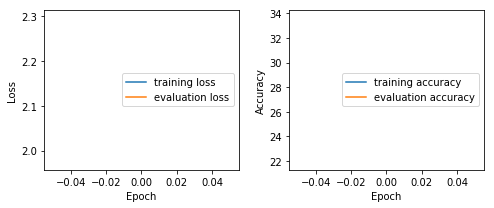

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## With Resnet18 Model:

In [10]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.pool1 = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.pool2 = resnet.avgpool
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        y = self.fc(x)
        return y

In [11]:
lr = 1e-3
net = Resnet18Transfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass1", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


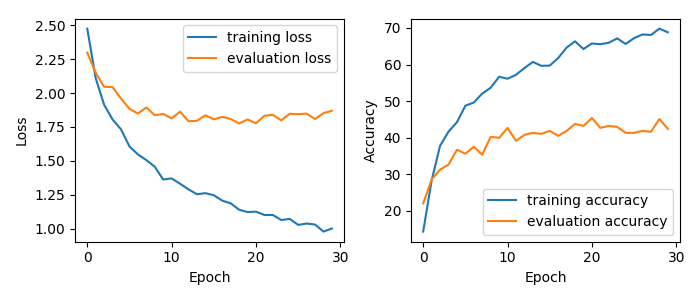

Start/Continue training from epoch 20
Epoch 21 (Time: 39.82s)
Epoch 22 (Time: 44.67s)
Epoch 23 (Time: 44.49s)
Epoch 24 (Time: 44.13s)
Epoch 25 (Time: 44.16s)
Epoch 26 (Time: 44.20s)
Epoch 27 (Time: 44.38s)
Epoch 28 (Time: 44.86s)
Epoch 29 (Time: 44.87s)
Epoch 30 (Time: 45.09s)
Finish training for 30 epochs


In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=30, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [19]:
test_dir = "images/test"
test_set = tv.datasets.ImageFolder(test_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

# test_img = Image.open("images/test/test1.png")
# transform = tv.transforms.Compose([
#     tv.transforms.Resize(image_size),
#     tv.transforms.ToTensor(),
#     normalize
#     ])

# new = transform(test_img)
# myimshow(new)

RuntimeError: Found 0 files in subfolders of: images/test
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif

### Performance comparison: 

In [24]:
vgg_eval = exp1.evaluate()
resnet_eval = exp2.evaluate()
print("Evaluation for VGG: {}".format(vgg_eval))
print("Evaluation for Resnet: {}".format(resnet_eval))

Evaluation for VGG: {'loss': 0.5196032709563556, 'accuracy': tensor(83.9674, device='cuda:0')}
Evaluation for Resnet: {'loss': 0.5815548119337662, 'accuracy': tensor(81.5217, device='cuda:0')}
